# Predict tags on StackOverflow titles with linear models

In this assignment you will learn how to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task you will use multilabel classification approach.

### Libraries

In this task you will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Data

The following cell will download all data required for this assignment into the folder `week1/data`.

In [1]:
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

File data\train.tsv is already downloaded.
File data\validation.tsv is already downloaded.
File data\test.tsv is already downloaded.
File data\text_prepare_tests.tsv is already downloaded.


### Text preprocessing

Stopwords will be removed. The list of stopwords can be downloaded from *nltk*:

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In this task you will deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). The *test* set doesn't contain answers. Upload the corpora using *pandas* and look at the data:

In [3]:
from ast import literal_eval # if a string is malformed, the ast.literal_eval(string) will throw ValueError
import pandas as pd
import numpy as np

In [4]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)   # make sure there is no malformed string in the tags
    return data

In [5]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')  # test set doesn't have 'tags'

In [6]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [7]:
validation.iloc[4]['title']

'Getting error - type "json" does not exist - in Postgresql during rake db migrate'

In [8]:
print(train.shape)
print(validation.shape)
print(test.shape)

(100000, 2)
(30000, 2)
(20000, 1)


In [9]:
train.tail()

,title,tags
99995,"Obj-c, incorrect checksum for freed object - o...","[iphone, objective-c, ios, cocoa-touch]"
99996,How to connect via HTTPS using Jsoup?,"[java, android]"
99997,Python Pandas Series of Datetimes to Seconds S...,"[python, datetime, pandas]"
99998,jqGrid issue grouping - Duplicate rows get app...,"[javascript, jquery]"
99999,Create a List of primitive int?,"[java, list, generics]"


As you can see, *title* column contains titles of the posts and *tags* column countains the tags. It should be noticed that the number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [10]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(100000,)
(100000,)
(30000,)
(30000,)
(20000,)


In [13]:
y_train[99995]

['iphone', 'objective-c', 'ios', 'cocoa-touch']

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent the problems, it's usually useful to prepare the data somehow. In this task you'll write a function, which will be also used in the other assignments. 

**Task 1 (TextPrepare).** Implement the function *text_prepare* following the instructions. After that, run the function *test_test_prepare* to test it on tiny cases.

In [14]:
import re

In [15]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')   # remove punctuations and parentheses
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')           # only allow the 40 characters
STOPWORDS = set(stopwords.words('english'))

In [16]:
len(STOPWORDS)

179

In [17]:
# REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
# BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
# STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()  # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text)          # delete symbols which are in BAD_SYMBOLS_RE from text
    # delete stopwors from text
    resultwords  = [word for word in text.split() if word not in STOPWORDS]    # remove stop words
    text = ' '.join(resultwords)
    return text

In [18]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [19]:
print(test_text_prepare())

Basic tests are passed.


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [20]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [21]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

For each tag and for each word calculate how many times they occur in the train corpus. 

**Task 2 (WordsTagsCount).** Find 3 most popular tags and 3 most popular words in the train data.

In [22]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

######################################
######### YOUR CODE HERE #############
for y in y_train:
    for t in y:
        if t in tags_counts:
            tags_counts[t] = tags_counts[t] + 1
        else:
            tags_counts[t] = 1

for x in X_train:
    for w in x.split():
        if w in words_counts:
            words_counts[w] = words_counts[w] + 1
        else:
            words_counts[w] = 1
######################################

In [23]:
print(len(tags_counts))
print(len(words_counts))

100
31497


In [27]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

print('3 most popular tags:', '%s\n3 most popular words: %s' % (', '.join(tag for tag, _ in most_common_tags), 
                                                ', '.join(word for word, _ in most_common_words)))

3 most popular tags: javascript, c#, java
3 most popular words: using, php, java


In [28]:
most_common_tags

[('javascript', 19078), ('c#', 19077), ('java', 18661)]

In [29]:
most_common_words

[('using', 8278), ('php', 5614), ('java', 5501)]

### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them.

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And interate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. You can test your code using the function *test_my_bag_of_words*.

In [30]:
DICT_SIZE = 5000

In [31]:
most_common_words_5000 = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]

In [32]:
WORDS_TO_INDEX = {}
INDEX_TO_WORDS = {}
for i, t in enumerate(most_common_words_5000):
    w = t[0]
    WORDS_TO_INDEX[w]=i
    INDEX_TO_WORDS[i]=w

In [33]:
ALL_WORDS = WORDS_TO_INDEX.keys()

In [34]:
# DICT_SIZE = 5000
# WORDS_TO_INDEX = ####### YOUR CODE HERE #######
# INDEX_TO_WORDS = ####### YOUR CODE HERE #######
# ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    ######################################
    ######### YOUR CODE HERE #############
    for w in text.split():
        if w in words_to_index:
            idx = words_to_index[w]
            result_vector[idx] = result_vector[idx] + 1  # this is cumulative count for multiple occurrence
    ######################################
    return result_vector

In [35]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [36]:
print(test_my_bag_of_words())

Basic tests are passed.


Now apply the implemented function to all samples (this might take up to a minute):

In [37]:
from scipy import sparse as sp_sparse

In [38]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however slkearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

**Task 3 (BagOfWords).** For the 10th row in *X_train_mybag* find how many non-zero elements it has.

In [39]:
X_train[10]

'obtaining object javalangclasst object parameterized type without constructing class q_uestion'

In [40]:
test_row = X_train_mybag[10].toarray()[0]
np.count_nonzero(test_row)

7

In [45]:
nonzero_idx = np.nonzero(test_row)[0].tolist()
print([INDEX_TO_WORDS[i] for i in nonzero_idx])

['object', 'class', 'type', 'without', 'parameterized', 'obtaining', 'constructing']


In [46]:
print(nonzero_idx)

[15, 16, 29, 51, 3095, 3326, 4550]


#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary. 

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [48]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return bag-of-words representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    tfidf_vectorizer = TfidfVectorizer(token_pattern='(\S+)', min_df=5, max_df=0.9, ngram_range=(1,2)) ####### YOUR CODE HERE #######
    
    ######################################
    ######### YOUR CODE HERE #############
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    ######################################
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once you have done text preprocessing, always have a look at the results. Be very careful at this step, because the performance of future models will drastically depend on it. 

In this case, check whether you have c++ or c# in your vocabulary, as they are obviously important tokens in our tags prediction task:

In [49]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [50]:
######### YOUR CODE HERE #############
tfidf_vocab['c++']

1976

In [51]:
tfidf_vocab['c#']

1879

In [56]:
print(X_train_tfidf.shape)
print(X_val_tfidf.shape)
print(X_test_tfidf.shape)

(100000, 18300)
(30000, 18300)
(20000, 18300)


If you can't find it, we need to understand how did it happen that we lost them? It happened during the built-in tokenization of TfidfVectorizer. Luckily, we can influence on this process. Get back to the function above and use '(\S+)' regexp as a *token_pattern* in the constructor of the vectorizer.  

### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [52]:
from sklearn.preprocessing import MultiLabelBinarizer

In [53]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [54]:
print(y_train.shape)
print(y_val.shape)

(100000, 100)
(30000, 100)


In [55]:
y_train[99995]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Implement the function *train_classifier* for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because the number of classifiers to train is large.

In [57]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [73]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.

    ######################################
    ######### YOUR CODE HERE #############
    classif = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
    classif.fit(X_train, y_train)
    return classif
    ######################################    

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [74]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [60]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [61]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(10):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails


Title:	sessions sinatra used pass variable
True labels:	ruby,session
Predicted labels:	


Title:	getting error type json exist postgresql rake db migrate
True labels:	json,ruby,ruby-on-rails
Predicted labels:	ruby-on-rails


Title:	library found
True labels:	c++,ios,iphone,xcode
Predicted labels:	


Title:	csproj file programmatic adding deleting files
True labels:	c#
Predicted labels:	


Title:	typeerror makedirs got unexpected keyword argument exists_ok
True labels:	django,python
Predicted labels:	python


Title:	pan div using jquery
True labels:	html,javascript,jquery
Predicted labels:	javascript,jquery


Title:	hibernate intermediate advanced tutorials
True labels:	hibernate,java
Predicted labe

Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [62]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [63]:
def print_evaluation_scores(y_val, predicted):
    
    ######################################
    ######### YOUR CODE HERE #############
    print('accuracy = {0}'.format(accuracy_score(y_val, predicted)))
    print('F1-score macro = {0}'.format(f1_score(y_val, predicted, average='macro')))
    print('F1-score micro = {0}'.format(f1_score(y_val, predicted, average='micro'))) 
    print('F1-score weighted = {0}'.format(f1_score(y_val, predicted, average='weighted')))
    print('average_precision_score macro = {0}'.format(average_precision_score(y_val, predicted, average='macro')))
    print('average_precision_score micro = {0}'.format(average_precision_score(y_val, predicted, average='micro'))) 
    print('average_precision_score weighted = {0}'.format(average_precision_score(y_val, predicted, average='weighted')))
    ######################################

In [64]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
accuracy = 0.358
F1-score macro = 0.5047325582597497
F1-score micro = 0.6710820449370445
F1-score weighted = 0.6486950381244107
average_precision_score macro = 0.34458812912520126
average_precision_score micro = 0.4812849070834009
average_precision_score weighted = 0.5108520393587743
Tfidf
accuracy = 0.33393333333333336
F1-score macro = 0.44570816904771116
F1-score micro = 0.6418085281077235
F1-score weighted = 0.614350867051105
average_precision_score macro = 0.30203064788106676
average_precision_score micro = 0.45698549290225043
average_precision_score weighted = 0.4850977390709925


You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [65]:
from metrics import roc_auc
%matplotlib inline

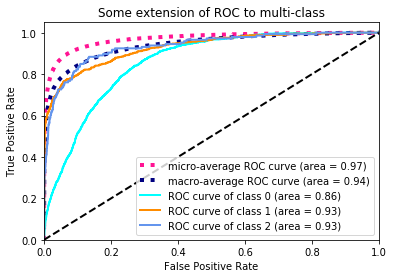

In [66]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

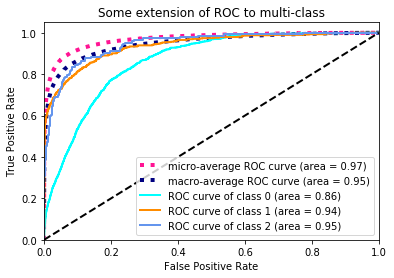

In [67]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

In [68]:
n_classes

100

**Task 4 (MultilabelClassification).** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use *F1-score weighted* as an evaluation metric. Our recommendation:
- compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
- for the chosen one, try *L1* and *L2*-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

You also could try other improvements of the preprocessing / model, if you want. 

In [72]:
######################################
######### YOUR CODE HERE #############
def train_classifier_tunable(X_train, y_train, norm='l2', regular=1.0):
    """
      X_train, y_train — training data
      penalty : str, ‘l1’ or ‘l2’, default: ‘l2’
      C : float, default: 1.0   Inverse of regularization strength; must be a positive float. smaller values specify stronger regularization.
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.

    ######################################
    ######### YOUR CODE HERE #############
    classif = OneVsRestClassifier(LogisticRegression(solver='liblinear', penalty=norm, C=regular))
    classif.fit(X_train, y_train)
    return classif
    ######################################    

for norm in ['l1','l2']:
    for reg in [0.1, 1, 10, 100]:
        classifier_mybag_tuned = train_classifier_tunable(X_train_mybag, y_train, norm, reg)
        y_val_predicted_labels_mybag_tuned = classifier_mybag_tuned.predict(X_val_mybag)
        print('norm = {0}, C = {1}, F1-score weighted = {2}'.format(norm, reg, f1_score(y_val, y_val_predicted_labels_mybag_tuned, average='weighted')))
######################################

norm = l1, C = 0.1, F1-score weighted = 0.6116000654698222
norm = l1, C = 1, F1-score weighted = 0.6560978217422109
norm = l1, C = 10, F1-score weighted = 0.6465499765781172
norm = l1, C = 100, F1-score weighted = 0.6183996219894728


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


norm = l2, C = 0.1, F1-score weighted = 0.5919941381102238
norm = l2, C = 1, F1-score weighted = 0.6486950381244107
norm = l2, C = 10, F1-score weighted = 0.6514620487180804
norm = l2, C = 100, F1-score weighted = 0.6328140034594975


In [75]:
selected_norm = 'l1'
selected_C = 1.0
classifier_mybag_selected = train_classifier_tunable(X_train_mybag, y_train, selected_norm, selected_C)
y_val_predicted_labels_mybag_selected = classifier_mybag_selected.predict(X_val_mybag)
print('norm = {0}, C = {1}, F1-score weighted = {2}'.format(selected_norm, selected_C, f1_score(y_val, y_val_predicted_labels_mybag_selected, average='weighted')))

norm = l1, C = 1.0, F1-score weighted = 0.6561090422925301


When you are happy with the quality, create predictions for *test* set.

In [84]:
test_predictions = classifier_mybag_selected.predict(X_test_mybag) ######### YOUR CODE HERE #############
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions = '\n'.join('%i\t%s\t%s' % (i, xt, ','.join(row)) for i, (xt, row) in enumerate(zip(X_test,test_pred_inversed)))
print(test_predictions)

0	warning mysql_query expects parameter 2 resource object given	mysql,php
1	get click coordinates input typeimage via javascript	javascript
2	implement cloud storage media assets zf	
3	catcomplete jquerys autocomplete plugin	javascript,jquery
4	error building android app cordova 31 cli	android,java
5	parse xml file php	php,xml
6	uploading files via json post request web service provided teambox	json,web-services
7	adding rows jtable right order	java,swing
8	read input file python	python
9	pdf generation html containing images text	html
10	trying get sql query dynamic jquery	jquery
11	fiting 2parameters weibull distribution tabulated data	
12	add six months php	php
13	code constants rails 3 application	ruby-on-rails
14	comparing list items one column datatable	c#
15	python sort upper case lower case	python,python-2.7
16	make pointer multidimensional array unknown size	
17	rails 3 trigger ajax submit radio button change rendering html response	ajax,html,javascript,jquery,ruby-on-rails
18

19999	reask input try catch statement	


In [82]:
X_test

['warning mysql_query expects parameter 2 resource object given',
 'get click coordinates input typeimage via javascript',
 'implement cloud storage media assets zf',
 'catcomplete jquerys autocomplete plugin',
 'error building android app cordova 31 cli',
 'parse xml file php',
 'uploading files via json post request web service provided teambox',
 'adding rows jtable right order',
 'read input file python',
 'pdf generation html containing images text',
 'trying get sql query dynamic jquery',
 'fiting 2parameters weibull distribution tabulated data',
 'add six months php',
 'code constants rails 3 application',
 'comparing list items one column datatable',
 'python sort upper case lower case',
 'make pointer multidimensional array unknown size',
 'rails 3 trigger ajax submit radio button change rendering html response',
 'source code apps windows8',
 'callback sockets linux',
 'queue python locks',
 'pandas rolling computation window based values instead counts',
 'wait process finis

In [85]:
classifier_mybag_selected.coef_.shape

(100, 5000)

In [86]:
classifier_mybag_selected.intercept_.shape

(100, 1)

In [87]:
total_wt_by_word = np.sum(classifier_mybag_selected.coef_,axis=0)
total_wt_by_word.shape

(5000,)

In [88]:
total_wt_by_word

array([-1.93234666e+01, -1.03419541e+02, -1.06094827e+02, ...,
        2.47352803e-03,  5.74819165e+00,  1.61548952e+00])

In [ ]:
# mlb.classes is a list  type(mlb.classes)
# len(mlb.classes)  100
# mlb.classes[:12]

In [89]:
idx=np.where(np.array(mlb.classes)=='linux')[0][0]
idx

44

In [91]:
classifier_mybag_selected.coef_[10].shape

(5000,)

### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

Implement the function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [92]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    
    ######################################
    ######### YOUR CODE HERE #############
    idx_of_tag=np.where(np.array(tags_classes)==tag)[0][0]
    idx_of_word_sorted_small_to_large = np.argsort(classifier.coef_[idx_of_tag])
    idx_top_5_words_largest_first = idx_of_word_sorted_small_to_large[-5:][::-1]
    idx_bottom_5_words_smallest_first = idx_of_word_sorted_small_to_large[:5]
    top_pos_words = []
    top_neg_words = []
    for k in idx_top_5_words_largest_first:
        top_pos_words.append(index_to_words[k])
    for j in idx_bottom_5_words_smallest_first:
        top_neg_words.append(index_to_words[j])
    ######################################
    
    # top_positive_words = # top-5 words sorted by the coefficiens.
    # top_negative_words = # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_pos_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_neg_words)))

In [93]:
print_words_for_tag(classifier_mybag_selected, 'c', mlb.classes, INDEX_TO_WORDS, ALL_WORDS)
print_words_for_tag(classifier_mybag_selected, 'c++', mlb.classes, INDEX_TO_WORDS, ALL_WORDS)
print_words_for_tag(classifier_mybag_selected, 'linux', mlb.classes, INDEX_TO_WORDS, ALL_WORDS)

Tag:	c
Top positive words:	c, malloc, scanf, fscanf, gtk
Top negative words:	objective, php, template, swift, begin

Tag:	c++
Top positive words:	c++, boost, stdstring, boostasio, mfc
Top negative words:	php, resharper, jquery, objectivec, swift

Tag:	linux
Top positive words:	linux, killed, centos, argv, shell_exec
Top negative words:	nokogiri, aspnet, red, javascript, codeigniter



In [94]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	c, malloc, scanf, printf, gcc
Top negative words:	java, php, python, javascript, c#

Tag:	c++
Top positive words:	c++, qt, boost, mfc, opencv
Top negative words:	java, php, python, javascript, c#

Tag:	linux
Top positive words:	linux, ubuntu, c, address, signal
Top negative words:	javascript, c#, jquery, array, method

